# Benchmark GMM Dorso

### Outline
* generate expression matrix - ground truth (atlas, see normal droso tutorial)
* generate expression matrix - normal reconstruction (see normal droso tutorial)
* generate expression matrix - GMM (see "cleaning demonstration) - maybe different modes

* calculate similarity values of the matrixes
* plot them

Infos:

"dge_rep" mode: None (there are different possibilities, maybe try other later)


# Imports and Packages

In [3]:
# install
# pip install novosparc
# imports
from importlib import reload

import anndata
%matplotlib inline

import importlib.util
import sys
spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
# spec = importlib.util.spec_from_file_location("novosparc", "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

# import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore
import sklearn
from sklearn.preprocessing import scale
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random
random.seed(42)

# working directory
# os.chdir("/home/vfs/PycharmProjects/rajewskyLab/novosparc") # when I use this the notebook does not use the normal novosparc anymore - but when I put the notebooke physically in that directory everything works normally - where does this come from?

<Figure size 432x288 with 0 Axes>

# Data
## Read in Single Cell data

In [4]:

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression
# highly var genes
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

number of cells: 1297
number of genes: 8924


## Read in atlas

In [5]:

# atlas settings
atlas_dir = '../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
type(locations)
num_locations = 3039 # coming from the spatial data
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations_apriori
locations = locations_apriori
locations
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

In [6]:
# expmtrx_truth = atlas.X


In [7]:
# zscore
# expmtrx_truth_normed = zscore(expmtrx_truth)
# expmtrx_truth_normed.shape

 # Reconstruction
 ## Reconstruction linear and smooth, alpha = 0.8, neighbours = 5

In [8]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# alternative 2: use atlas only
# tissue.setup_linear_cost(markers_to_use, atlas_matrix)

# tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge

dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations
# GMM
tissue.cleaning_expression_data(dataset_reconst,tissue.sdge.T,normalization='zscore', selected_genes=atlas_genes)
# reconstructed expression of individual genes
sdge_postcleaned = tissue.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations

Setting up for reconstruction ... done ( 4.0 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_166609/1551037356.py:38: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try diff

### check seperate gene set for reconstruction accuracy

truth
pl genes


<Figure size 432x288 with 0 Axes>

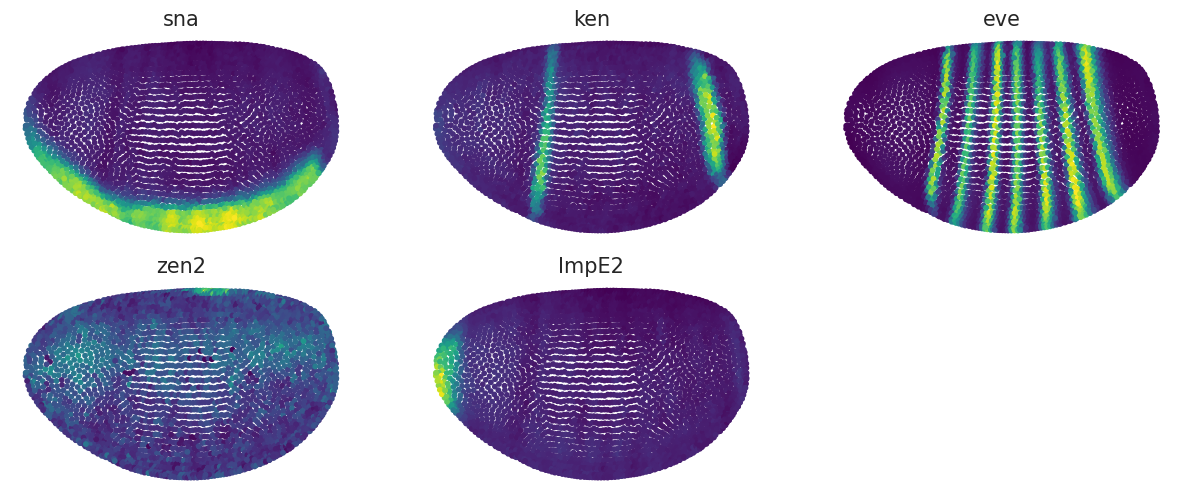

failing genes


<Figure size 432x288 with 0 Axes>

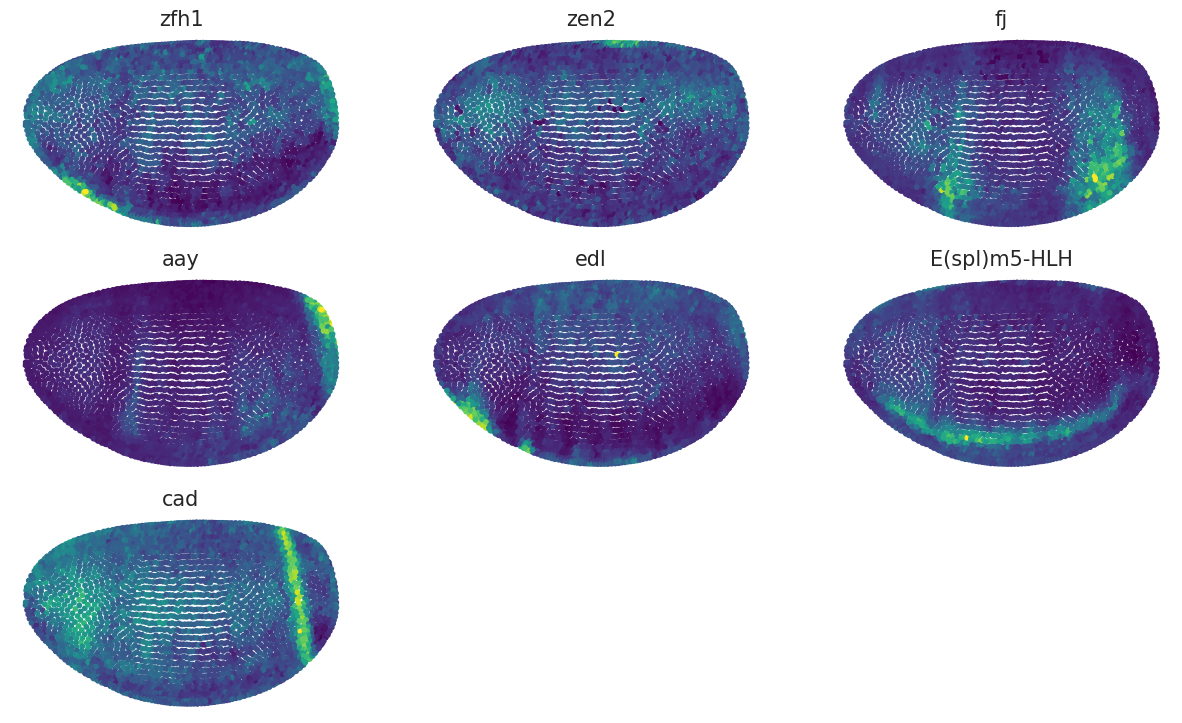

reconstructed
pl genes


<Figure size 432x288 with 0 Axes>

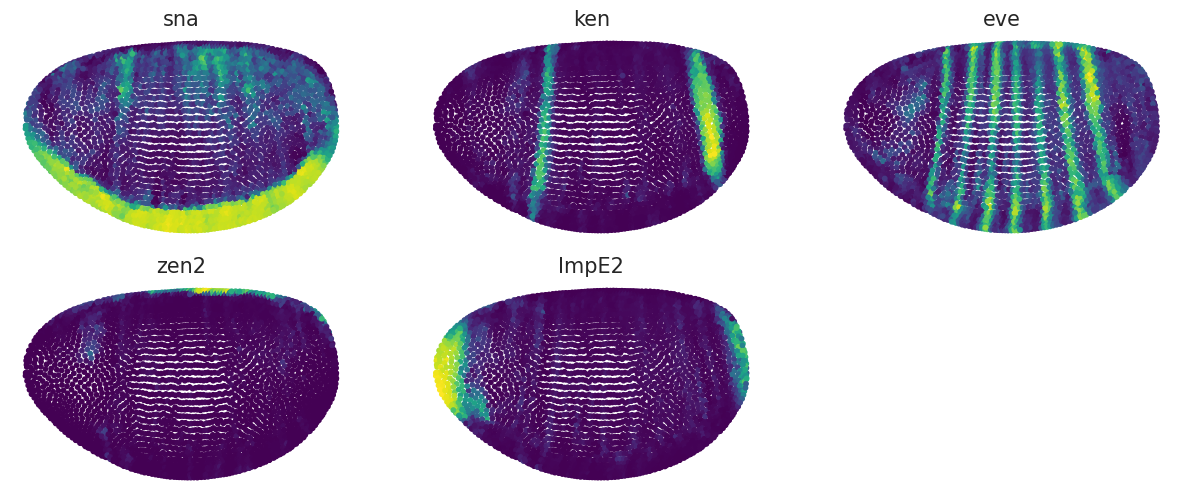

failing genes


<Figure size 432x288 with 0 Axes>

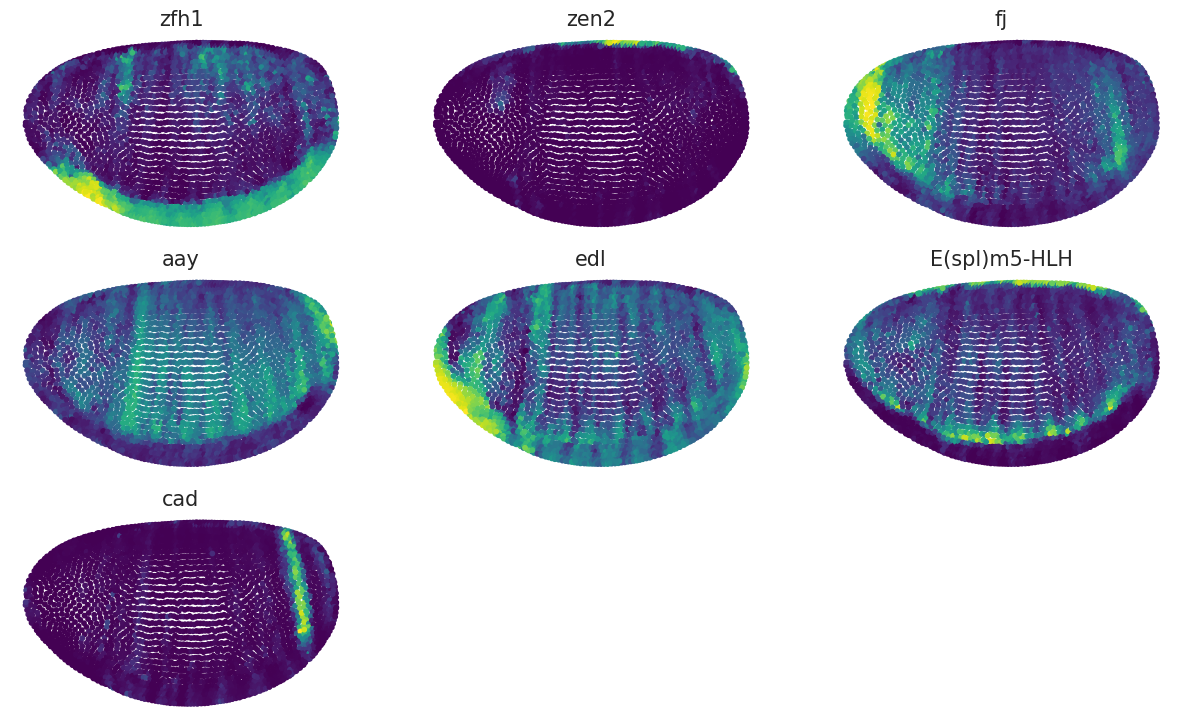

<Figure size 432x288 with 0 Axes>

In [12]:
wrong_reconstructed_genes = ["zfh1", "zen2", "fj", "aay", "edl", "E(spl)m5-HLH", "cad"]
pl_genes = ['sna', 'ken', 'eve','zen2','ImpE2']

# test
plt.viridis()
print("truth")
print("pl genes")
novosparc.pl.embedding(atlas, pl_genes)
print("failing genes")
novosparc.pl.embedding(atlas, wrong_reconstructed_genes)
print("reconstructed")
print("pl genes")
novosparc.pl.embedding(dataset_reconst, pl_genes)
print("failing genes")
novosparc.pl.embedding(dataset_reconst, wrong_reconstructed_genes)

# Similarity scoring
## Merging matrix and scale together

In [10]:
# # For this you have to define the expression matrixes first

# exprssn_mtrx_all = np.concatenate((exprmtrx_truth, exprmtrx_simplerecon, exprmtrx_recon_defaultGMM), axis=1)
# print(exprmtrx_truth.shape)
# print(exprmtrx_simplerecon.shape)
# print(exprmtrx_recon_defaultGMM.shape)
# print(exprssn_mtrx_all.shape)

In [51]:
exprssn_mtrx_all_scaled = scale(exprssn_mtrx_all)
expmtrx_truth_scaled = exprssn_mtrx_all_scaled[:,0:84]
exprmtrx_simplerecon_scaled = exprssn_mtrx_all_scaled[:,84:168]
exprmtrx_recon_defaultGMM_scaled = exprssn_mtrx_all_scaled[:,168:252]

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
